In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
from scipy.stats import *
import copy
import seaborn as sns
from Test import *
import math

In [14]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [15]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(50,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 0   #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)

var = 30                  # Standard deviation for Gaussian noise
mean = 2000                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 1              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 500
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))

Control = Data.copy()

num_nodes: 50
IteNumber of Corrupt nodesration 0, Corrupt nodes: []


In [16]:
def normpdf(x, mn, var):
    denom = (2 * np.pi * var)**0.5 
    num = np.exp(-((x - mn)**2) / (2 * var + 1e-6)) 
    return num / (denom + 1e-6)

In [17]:
# Define the normal probability density function
def shownormpdf(mn, var):
    # Step 2: Create x values (input range)
    x = np.linspace(-10, 20, 500)  # Adjust the range to better visualize the Gaussian

    # Step 3: Compute y values (apply the function)
    y = normpdf(x,mn,var)

    # Step 4: Plot the function
    plt.plot(x, y, label='Normal PDF (mean={mn}, variance={var})'.format(mn=mn, var=var))

    # Step 5: Customize the plot
    plt.title("Plot of Normal Probability Density Function")  # Add title
    plt.xlabel("x")  # Label x-axis
    plt.ylabel("f(x)")  # Label y-axis
    plt.axhline(0, color='black', linewidth=0.5)  # Add x-axis line
    plt.axvline(0, color='black', linewidth=0.5)  # Add y-axis line
    plt.grid(True)  # Add grid
    plt.legend()

    # Step 6: Show the plot
    plt.show()
    return 0


In [18]:
def nodeSelection(max_iters, num_nodes):
    #Selecting nodes for its turn
    nodes_list = []
    for i in range(max_iters):
        nodes_list.append(np.random.randint(0,num_nodes))
    return nodes_list

In [19]:
def PDMM(Data, G, avg_temp, tolerance, c, max_iters, Control, averaging):
    """
    PDMM with mid-iteration node removal:
      - At iteration floor(max_iters/2), remove one node entirely.
      - Recompute avg_temp, skip that node in all future calculations.
    """
    # ------------------------------------------------
    # 1) Seeding for reproducibility
    # ------------------------------------------------
    Seed = 2001
    random.seed(Seed)
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    # ------------------------------------------------
    # 2) Initialization
    # ------------------------------------------------
    num_nodes = G.number_of_nodes()
    x = np.zeros([num_nodes, 1])
    converged = False
    Error = np.array([])

    mean_estimate = np.zeros([num_nodes, 1])
    var_estimate  = np.zeros([num_nodes, 1])

    # Build your incidence/adjacency structure
    A_ij = calc_incidence_nested(G)

    # PDMM state variables
    z         = np.zeros((num_nodes, num_nodes))
    y         = np.zeros((num_nodes, num_nodes))
    dual      = np.zeros((num_nodes, num_nodes))
    calc_dual = np.zeros((num_nodes, num_nodes))
    calc_x    = np.zeros([num_nodes, 1])
    temp_y    = np.zeros((num_nodes, num_nodes))

    dual_history      = []
    dual_calc_history = []
    x_history         = []
    x_calc_history    = []
    z_history         = []

    count = 0
    removed_node = None  # will store the node to remove
    removed_iteration = max_iters // 2  # round at which we remove the node

    # ------------------------------------------------
    # 3) PDMM Iterations
    # ------------------------------------------------
    while not converged and count < max_iters:
        # --------------------------------------------
        # 3A) Check if we should remove a node now
        #     (only happens once)
        # --------------------------------------------
        if count == removed_iteration and removed_node is None:
            # (a) Choose a node to remove
            removed_node = random.choice(list(G.nodes()))
            print(f"\n=== Removing node {removed_node} at iteration {count} ===")

            # (b) Remove it from the graph's edges
            #     so G.degree(removed_node) -> 0
            #     But we do NOT call G.remove_node(...) 
            #     because that would reindex all node IDs.
            #     Instead, remove edges and skip it in loops.
            neighbors_to_remove = list(G.neighbors(removed_node))
            for nbd in neighbors_to_remove:
                G.remove_edge(removed_node, nbd)

            # (c) Recompute avg_temp ignoring this node's data
            #     Because we no longer want it in the "target average".
            #     For a 1D Data array, ignoring one node is:
            #         new_avg = mean of Data for all nodes != removed_node
            #     We can do that by building an index set.
            idxs = list(range(num_nodes))
            idxs.remove(removed_node)  # remove that node's index
            # Now avg_temp is the new average
            avg_temp = np.mean(Data[idxs])

            print(f"New avg_temp after removal of node {removed_node}: {avg_temp}")

        # --------------------------------------------
        # 3B) Update x
        # --------------------------------------------
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            # Skip removed_node in all updates
            if i == removed_node:
                # keep it the same or zero it out
                x_new[i] = x[i]
                continue

            # PDMM numerator for node i
            numerator_i = float(Data[i])
            for j in G.neighbors(i):
                # skip if neighbor is removed
                if j == removed_node:
                    continue
                numerator_i += -A_ij[i][j] * z[i][j]

            denom_i = 1 + c * G.degree(i)  # G.degree(i) might be 0 if all edges removed
            if denom_i == 0:
                x_new[i] = x[i]  # can't update if degree is zero
            else:
                x_new[i] = numerator_i / denom_i

        x = x_new
        x_history.append(x.copy())

        # --------------------------------------------
        # 3C) Update dual
        # --------------------------------------------
        for i in range(num_nodes):
            if i == removed_node:
                continue
            for j in G.neighbors(i):
                if j == removed_node:
                    continue
                dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
        dual_history.append(dual.copy())

        # --------------------------------------------
        # 3D) Update y and z
        # --------------------------------------------
        for i in range(num_nodes):
            if i == removed_node:
                continue
            for j in G.neighbors(i):
                if j == removed_node:
                    continue
                temp_y[i][j] = y[i][j]
                y[i][j] = 2 * dual[i][j] - z[i][j]

        for i in range(num_nodes):
            if i == removed_node:
                continue
            for j in G.neighbors(i):
                if j == removed_node:
                    continue
                calc_dual[i][j] = (y[j][i] + temp_y[i][j]) / 2
                # denom = (c * A_ij[i][j] * -1)
                # but watch for potential 0 or skip removed
                calc_x[j] = (calc_dual[i][j] - temp_y[i][j]) / (c * A_ij[i][j] * -1) if A_ij[i][j] != 0 else 0.0

                # Weighted average update
                z[i][j] = (1 - averaging) * z[i][j] + averaging * y[j][i]

        dual_calc_history.append(calc_dual.copy())
        x_calc_history.append(calc_x.copy())
        z_history.append(z.copy())

        # --------------------------------------------
        # 3E) Convergence check
        # --------------------------------------------
        # skip removed_node in the diff => set to 0 for that node
        diff = x - avg_temp
        if removed_node is not None:
            diff[removed_node] = 0  # removed node does not affect convergence

        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)
        count += 1

        if norm_diff < tolerance:
            print(f"Iteration {count}, Norm of difference: {norm_diff:.8f}")
            converged = True

        # --------------------------------------------
        # 3F) Estimate mean, variance for each node
        # --------------------------------------------
        for i in range(num_nodes):
            if i == removed_node:
                mean_estimate[i] = 0
                var_estimate[i]  = 0
                continue

            neighbors_i = list(G.neighbors(i))
            deg_i = len(neighbors_i)
            if deg_i == 0:
                mean_estimate[i] = 0
                var_estimate[i] = 0
                continue
            mean_sum = 0
            for j in neighbors_i:
                mean_sum += dual[i][j]
            mean_estimate[i] = mean_sum / deg_i

            var_sum = 0
            for j in neighbors_i:
                var_sum += (dual[i][j] - mean_estimate[i]) ** 2
            var_estimate[i] = var_sum / deg_i

    # ------------------------------------------------
    # 4) Collect final results
    # ------------------------------------------------
    dual_values = []
    for i in range(num_nodes):
        for j in G.neighbors(i):
            dual_values.append(dual[j][i])

    print(f"PDMM completed in {count} iterations.")
    print(f"Final x:\n{x}")

    return (
        Error,
        count,
        dual_history,
        x_history,
        z_history,
        dual_calc_history,
        x_calc_history
    )


In [20]:
# def PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging):
#     Seed = 2001  # for reproducibility
#     random.seed(Seed)
#     np.random.seed(Seed) 
#     torch.manual_seed(Seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(Seed)
#         torch.cuda.manual_seed_all(Seed)


#     num_nodes = G.number_of_nodes()
#     x=np.zeros([num_nodes,1])
#     converged = False
#     Error = np.array([])
#     mean_estimate=np.zeros([num_nodes,1])
#     var_estimate=np.zeros([num_nodes,1])

#     #initialise A_ij
#     A_ij=calc_incidence_nested(G)

#     #initialise z_ij and y_ij
#     z = np.zeros((num_nodes, num_nodes))
#     y = np.zeros((num_nodes, num_nodes))
#     dual = np.zeros((num_nodes, num_nodes))
#     calc_dual = np.zeros((num_nodes, num_nodes))
#     calc_x = np.zeros([num_nodes,1])
#     temp_y = np.zeros((num_nodes, num_nodes))

#     dual_history = [] 
#     dual_calc_history = [] 
#     x_history = [] 
#     x_calc_history = [] 
#     z_history = []
#     count=0
#     k=0
#     z_values = np.zeros_like(z)
#     while not converged and count < max_iters:

#         x_new = np.zeros_like(x)
#         for i in range(num_nodes):
#             numerator_i = Data[i].copy()
#             for j in G.neighbors(i):
#                 numerator_i += -A_ij[i][j]*z[i][j]
#             x_new[i]=numerator_i/(1+c*G.degree(i))
#         x = x_new

#         x_history.append(x.copy())  # Store dual values for this iteration

#         for i in range(num_nodes):   
#             for j in G.neighbors(i):
#                 dual[i][j] = z[i][j] + c*(x[i]*A_ij[i][j])
        
#         dual_history.append(dual.copy())  # Store dual values for this iteration

#         for i in range(num_nodes):   
#             for j in G.neighbors(i):
#                 temp_y[i][j] = y[i][j]
#                 y[i][j]=2*dual[i][j] - z[i][j]

#         for i in range(num_nodes):
#             for j in G.neighbors(i):    
#                 calc_dual[i][j] = (y[j][i] + temp_y[i][j])/2
#                 calc_x[j] = (calc_dual[i][j] - temp_y[i][j])/(c *A_ij[i][j]*-1)
#                 z[i][j] = (1 - averaging) * z[i][j] + averaging * y[j][i]  # Averaging with alpha

#         dual_calc_history.append(calc_dual.copy())  # Store dual values for this iteration
#         x_calc_history.append(calc_x.copy())  # Store dual values for this iteration

#         z_history.append(z.copy())  # Store dual values for this iteration
        

#         diff = x - avg_temp
#         norm_diff = np.linalg.norm(diff)
#         Error = np.append(Error, norm_diff)
#         count += 1
#         if norm_diff < tolerance:
#             print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
#             converged = True


#         for i in range(num_nodes):
#             mean_sum = 0   
#             for j in G.neighbors(i):
#                 mean_sum += dual[i][j]
#             mean_estimate[i] = mean_sum / (G.degree(i))
        

#         for i in range(num_nodes):
#             var_sum = 0
#             for j in G.neighbors(i):
#                     var_sum += (dual[i][j] - mean_estimate[i]) ** 2
#             var_estimate[i] = var_sum / (G.degree(i))


#     dual_values = []
#     for i in range(num_nodes):
#         for j in G.neighbors(i):
#                 dual_values.append(dual[j][i])

#     # true_mean_y = np.mean(dual_values)
#     # true_var_y = np.var(dual_values)
#     # print(true_var_y)

#     # # Plot histogram of dual_values with dual y-axes
#     # fig, ax1 = plt.subplots(figsize=(12, 6))

#     # # Plot histogram with frequency on the right axis
#     # n, bins, patches = ax1.hist(dual_values, bins=30, density=False, alpha=0.6, color='blue', label="Histogram (Frequency)")
#     # ax1.set_xlabel("Dual Values")
#     # ax1.set_ylabel("Frequency", color='blue')
#     # ax1.tick_params(axis='y', labelcolor='blue')

#     # # Create a second y-axis for the density plot
#     # ax2 = ax1.twinx()

#     # # Fit and plot normal distribution
#     # x_plot = np.linspace(min(dual_values), max(dual_values), 1000)
#     # pdf = norm.pdf(x_plot, loc=true_mean_y, scale=np.sqrt(true_var_y))
#     # ax2.plot(x_plot, pdf, 'r-', label=f"Normal PDF (mean={true_mean_y:.2f}, std={true_var_y:.2f})")
#     # ax2.set_ylabel("Density", color='red')
#     # ax2.tick_params(axis='y', labelcolor='red')

#     # # Add legends and title
#     # fig.suptitle("Histogram and Fitted Normal Distribution")
#     # fig.legend(loc="upper right")
#     # plt.grid(True)
#     # plt.show()


#     # # Plot mean estimates and true mean
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(range(num_nodes), mean_estimate, label="Estimated Means", marker='o', linestyle='-', color='blue')
#     # plt.axhline(true_mean_y, color='red', linestyle='--', label=f"True Mean ({true_mean_y:.4f})")
#     # plt.xlabel("Node Index")
#     # plt.ylabel("Mean Estimate")
#     # plt.title("Node-wise Mean Estimate vs. True Mean")
#     # plt.legend()
#     # plt.grid(True)
#     # plt.show()

#     # # Plot the variance estimates and the true variance
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(range(num_nodes), var_estimate, label="Estimated Variances", marker='o', linestyle='-', color='green')
#     # plt.axhline(true_var_y, color='red', linestyle='--', label=f"True Variance ({true_var_y:.4f})")
#     # plt.xlabel("Node Index")
#     # plt.ylabel("Variance Estimate")
#     # plt.title("Node-wise Variance Estimate vs. True Variance")
#     # plt.legend()
#     # plt.grid(True)
#     # plt.show()
    
#     print(f"x = {x}")            
#     return Error,count, dual_history, x_history, z_history, dual_calc_history, x_calc_history

In [21]:
# def PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging,Timer,K_decision,rejection_threshold):
#     Seed = 2001  # for reproducibility
#     random.seed(Seed)
#     np.random.seed(Seed) 
#     torch.manual_seed(Seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(Seed)
#         torch.cuda.manual_seed_all(Seed)


#     num_nodes = G.number_of_nodes()

    
#     x=np.zeros([num_nodes,1])
#     converged = False
#     Error = np.array([])
#     mean_estimate=np.zeros([num_nodes,1])
#     var_estimate=np.zeros([num_nodes,1])

#     #initialise A_ij
#     A_ij=calc_incidence_nested(G)

#     #initialise z_ij and y_ij
#     z = np.zeros((num_nodes, num_nodes))
#     y = np.zeros((num_nodes, num_nodes))
#     dual = np.zeros((num_nodes, num_nodes))
#     calc_dual = np.zeros((num_nodes, num_nodes))
#     calc_x = np.zeros([num_nodes,1])
#     temp_y = np.zeros((num_nodes, num_nodes))

#     sum_check = np.zeros((num_nodes, num_nodes))
#     # save_Check = np.zeros(( num_nodes, num_nodes))
#     mask = np.ones((num_nodes, num_nodes), dtype=bool)
#     immediate_reject = np.zeros((num_nodes, num_nodes), dtype=bool)
#     reject_count = np.zeros((num_nodes, num_nodes), dtype=int)

#     dual_history = [] 
#     dual_calc_history = [] 
#     y_history = []
#     x_history = [] 
#     x_calc_history = [] 
#     z_history = []
#     count=0
#     Track = 0
#     z_values = np.zeros_like(z)
#     dual_calc_history.append(calc_dual.copy())

#     while not converged and count < max_iters:

#         x_new = np.zeros_like(x)
#         for i in range(num_nodes):
#             numerator_i = Data[i].copy()
#             for j in G.neighbors(i):
#                 if mask[i][j]:
#                     numerator_i += -A_ij[i][j]*z[i][j]
#             x_new[i]=numerator_i/(1+c*G.degree(i))
#         x = x_new

#         x_history.append(x.copy())  # Store dual values for this iteration

#         for i in range(num_nodes):   
#             for j in G.neighbors(i):
#                 if mask[i][j]:
#                     dual[i][j] = z[i][j] + c*(x[i]*A_ij[i][j])
        
#         dual_history.append(dual.copy())  # Store dual values for this iteration

#         for i in range(num_nodes):   
#             for j in G.neighbors(i):
#                 if mask[i][j]:
#                     temp_y[i][j] = y[i][j]
#                     y[i][j]=2*dual[i][j] - z[i][j]

#         y_history.append(y.copy())  # Store dual values for this iteration

#         for i in range(num_nodes):
#             for j in G.neighbors(i):    
#                 calc_dual[j][i] = (y[j][i] + temp_y[i][j])/2
#         if count % 2 == 0:
#             sum_check += check(calc_dual, dual_calc_history[count] , i, c, num_nodes)
#             # sum_check += check(abs(y), abs(y_history[count]) , i, c, num_nodes)


#         if count % Timer == 0:
#             for i in range(num_nodes):
#                 for j in G.neighbors(i):
#                     if (sum_check[i][j]*2)/Timer < rejection_threshold * np.sqrt(G.degree(i)):
#                         # Increase rejection count: mark this j as rejected for this decision moment.
#                         reject_count[i][j] += 1
#                         immediate_reject[i][j] = True
#                     else:
#                         immediate_reject[i][j] = False
#         Track += 1
            
#         if Track % K_decision == 0:
#             for i in range(num_nodes):
#                 for j in G.neighbors(i):
#                         mask[i][j] = True

#         if Track % K_decision == 0:
#             for i in range(num_nodes):
#                 for j in G.neighbors(i):
#                     rejection_ratio = reject_count[i][j] / K_decision
#                     if rejection_ratio > 1/2:
#                         mask[i][j] = False  # Mark as permanently rejected until the next decision period.
#                         print(f"""Node {i} rejected node {j}""")

#                     else:
#                         mask[i][j] = True   # Otherwise, remain accepted.
#                     # Reset the rejection count for the next decision period.
#                     reject_count[i][j] = 0
#                     sum_check = np.zeros((num_nodes, num_nodes))


#         for i in range(num_nodes):
#             for j in G.neighbors(i):
#                 calc_x[j] = (calc_dual[j][i] - temp_y[i][j])/(c *A_ij[i][j]*-1)
#                 if not mask[i][j] or immediate_reject[i][j]:
#                     # If j is rejected, set z[i][j] to 0
#                     z[i][j] = 0
#                 else:
#                     # If j is accepted, update z[i][j] normally (with averaging)
#                     z[i][j] = (1 - averaging) * z[i][j] + averaging * y[j][i] # Averaging with alpha

#         dual_calc_history.append(calc_dual.copy())  # Store dual values for this iteration
#         x_calc_history.append(calc_x.copy())  # Store dual values for this iteration

#         z_history.append(z.copy())  # Store dual values for this iteration
        

#         diff = x[true_nodes] - avg_temp
#         # diff = x - avg_temp

#         norm_diff = np.linalg.norm(diff)
#         Error = np.append(Error, norm_diff)
#         count += 1
#         if norm_diff < tolerance:
#             print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
#             converged = True


#         # for i in range(num_nodes):
#         #     mean_sum = 0   
#         #     for j in G.neighbors(i):
#         #         mean_sum += dual[i][j]
#         #     mean_estimate[i] = mean_sum / (G.degree(i))
        

#         # for i in range(num_nodes):
#         #     var_sum = 0
#         #     for j in G.neighbors(i):
#         #             var_sum += (dual[i][j] - mean_estimate[i]) ** 2
#         #     var_estimate[i] = var_sum / (G.degree(i))

#     # dual_values = []
#     # for i in range(num_nodes):
#     #     for j in G.neighbors(i):
#     #             dual_values.append(dual[j][i])

#     # true_mean_y = np.mean(dual_values)
#     # true_var_y = np.var(dual_values)
#     # print(true_var_y)

#     # # Plot histogram of dual_values with dual y-axes
#     # fig, ax1 = plt.subplots(figsize=(12, 6))

#     # # Plot histogram with frequency on the right axis
#     # n, bins, patches = ax1.hist(dual_values, bins=30, density=False, alpha=0.6, color='blue', label="Histogram (Frequency)")
#     # ax1.set_xlabel("Dual Values")
#     # ax1.set_ylabel("Frequency", color='blue')
#     # ax1.tick_params(axis='y', labelcolor='blue')

#     # # Create a second y-axis for the density plot
#     # ax2 = ax1.twinx()

#     # # Fit and plot normal distribution
#     # x_plot = np.linspace(min(dual_values), max(dual_values), 1000)
#     # pdf = norm.pdf(x_plot, loc=true_mean_y, scale=np.sqrt(true_var_y))
#     # ax2.plot(x_plot, pdf, 'r-', label=f"Normal PDF (mean={true_mean_y:.2f}, std={true_var_y:.2f})")
#     # ax2.set_ylabel("Density", color='red')
#     # ax2.tick_params(axis='y', labelcolor='red')

#     # # Add legends and title
#     # fig.suptitle("Histogram and Fitted Normal Distribution")
#     # fig.legend(loc="upper right")
#     # plt.grid(True)
#     # plt.show()


#     # # Plot mean estimates and true mean
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(range(num_nodes), mean_estimate, label="Estimated Means", marker='o', linestyle='-', color='blue')
#     # plt.axhline(true_mean_y, color='red', linestyle='--', label=f"True Mean ({true_mean_y:.4f})")
#     # plt.xlabel("Node Index")
#     # plt.ylabel("Mean Estimate")
#     # plt.title("Node-wise Mean Estimate vs. True Mean")
#     # plt.legend()
#     # plt.grid(True)
#     # plt.show()

#     # # Plot the variance estimates and the true variance
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(range(num_nodes), var_estimate, label="Estimated Variances", marker='o', linestyle='-', color='green')
#     # plt.axhline(true_var_y, color='red', linestyle='--', label=f"True Variance ({true_var_y:.4f})")
#     # plt.xlabel("Node Index")
#     # plt.ylabel("Variance Estimate")
#     # plt.title("Node-wise Variance Estimate vs. True Variance")
#     # plt.legend()
#     # plt.grid(True)
#     # plt.show()
    
#     print(f"x = {x[true_nodes]}")            
#     return Error,count, dual_history, x_history, z_history, dual_calc_history, x_calc_history

In [22]:
def ADMM(Data, G, avg_temp, tolerance, rho, max_iters, Control):
    Seed = 2001  # for reproducibility
    random.seed(Seed)
    np.random.seed(Seed) 
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x = np.zeros((num_nodes,1))
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    y_history = [] 
    x_history = [] 
    z_history = []
    Error = np.array([])
    count = 0
    converged = False

    while not converged and count < max_iters:
        # Synchronous update for x
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            neighbors_i = list(G.neighbors(i))
            numerator_i = Data[i].copy()
            for nbr in neighbors_i:
                numerator_i += rho * z[i][nbr] - y[i][nbr]
            x_new[i] = numerator_i / (1 + rho * G.degree(i))
        x = x_new
        x_history.append(x.copy())  # Store dual values for this iteration

        # Synchronous update for z and y
        for i in range(num_nodes):
            for j in G.neighbors(i):
                z_val = 0.5 * (x[i] + x[j])
                z[i][j] = z_val
        z_history.append(z.copy())  # Store dual values for this iteration
        for i in range(num_nodes):
            for j in G.neighbors(i):
                y[i][j] = y[i][j] + rho * (x[i] - z[i][j])
        y_history.append(y.copy())  # Store dual values for this iteration
        diff = x - avg_temp
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)
        count += 1
        if norm_diff < tolerance:
            print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
            converged = True

    print(f"x = {x}")
    return Error, count, y_history, x_history, z_history


In [23]:
def main():
    calc_mean = 0
    max_iters=200             #PDMM max iterations
    averaging = 1/2         #Averaging alpha
    tolerance=-1        #PDMM tolerance
    c=0.4                     #PDMM c
    nodes_list = nodeSelection(max_iters, num_nodes)
    avg_temp = np.mean(Data)
    for i in range(num_nodes):
        if CorruptClients[i] == 1:
                Data[i] = np.random.normal(mean,  np.sqrt(var))

    print(avg_temp)
    Error = []
    Error_A = []
    Error, Transmission,dual_P, x_P, z_P, dual_calc, x_calc_history = PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging)
    # Error_A, Transmission,dual_A, x_A, z_A = ADMM(Data, G, avg_temp, tolerance, c, max_iters,Control)
    # print(f"Dual average PDMM = {np.mean(dual_P)} Dual Average ADMM = {np.mean(dual_A)}")  
    
    # min_iterations = min(len(dual_P), len(dual_A))

    # differences = []
    # differences_calc = []
    # differences_x = []
    # differences_x_calc = []
    # differences_z = []
    
    # for i in range(min_iterations):
    #     # Compute the difference (e.g., Frobenius norm) for iteration i
    #     diff = np.linalg.norm(dual_P[i] - dual_A[i], 'fro')
    #     diff_x = np.linalg.norm(x_P[i] - x_A[i], 'fro')
    #     diff_x_calc = np.linalg.norm(x_P[i] - x_calc_history[i], 'fro')
    #     diff_z = np.linalg.norm(z_P[i] - z_A[i], 'fro')
    #     diff_calc = np.linalg.norm(dual_calc[i] - dual_P[i], 'fro')

    #     differences.append(diff)
    #     differences_calc.append(diff_calc)
    #     differences_x.append(diff_x)    
    #     differences_x_calc.append(diff_x_calc)
    #     differences_z.append(diff_z)

    # plt.plot(range(1, len(differences_x_calc) + 1), differences_x_calc, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of x vs Calc Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # plt.plot(range(1, len(differences_calc) + 1), differences_calc, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of Dual vs Calc Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # plt.plot(range(1, len(differences) + 1), differences, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of Dual Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # plt.plot(range(1, len(differences_x) + 1), differences_x, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of x Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    
    # plt.plot(range(1, len(differences_z) + 1), differences_z, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of z Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # Plot  error
    plt.plot(range(len(Error)), Error, label='PDMM Convergence')
    # plt.plot(range(len(Error_A)), Error_A, label='ADMM Convergence')
    plt.yscale('log')
    plt.title('Error Convergence Over Iteration Rounds')
    plt.xlabel('Iteration Round')
    plt.ylabel('Norm Error')
    plt.legend()

24.522419874368385


C:\Users\za_re\AppData\Local\Temp\ipykernel_27076\1169140267.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  numerator_i = float(Data[i])
C:\Users\za_re\AppData\Local\Temp\ipykernel_27076\1169140267.py:121: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])



=== Removing node 37 at iteration 100 ===
New avg_temp after removal of node 37: 24.15235632532152
PDMM completed in 200 iterations.
Final x:
[[24.15235633]
 [24.15235632]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235632]
 [24.15235633]
 [24.15235632]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235632]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235632]
 [24.15235632]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235632]
 [24.15235633]
 [24.15235632]
 [24.15235632]
 [24.52241989]
 [24.15235632]
 [24.15235632]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235632]
 [24.15235633]
 [24.15235633]
 [24.15235633]
 [24.15235632]]


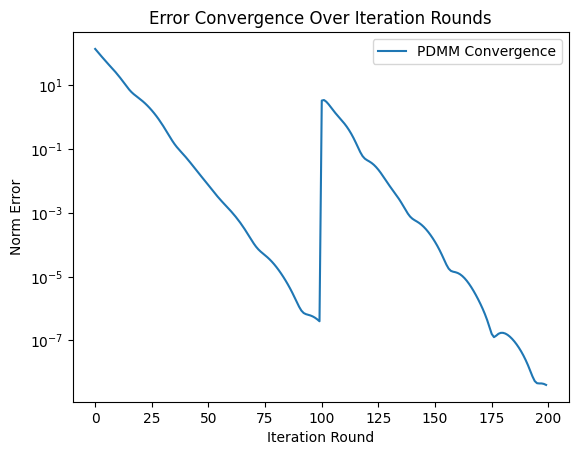

In [24]:
if __name__ == '__main__':
    main()